In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sun Jan 28 20:09:09 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   48C    P0    71W / 300W |    881MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_exclusive3_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 0.001953125
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.28-1_1e-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 255892
-rw-rw-r-- 1 scpark scpark    94591  1월 28 20:09 events.out.tfevents.1706440067.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7472764  1월 28 20:08 save_0
-rw-rw-r-- 1 scpark scpark       40  1월 28 20:07 events.out.tfevents.1706439866.GPUSVR11
-rw-rw-r-- 1 scpark scpark 42350227  1월 28 20:01 events.out.tfevents.1706413025.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:54 save_280000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:39 save_270000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:23 save_260000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:08 save_250000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:52 save_240000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:37 save_230000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:21 save_220000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:06 save_210000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:50 save_200000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:35 save_190000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:19 save_

### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

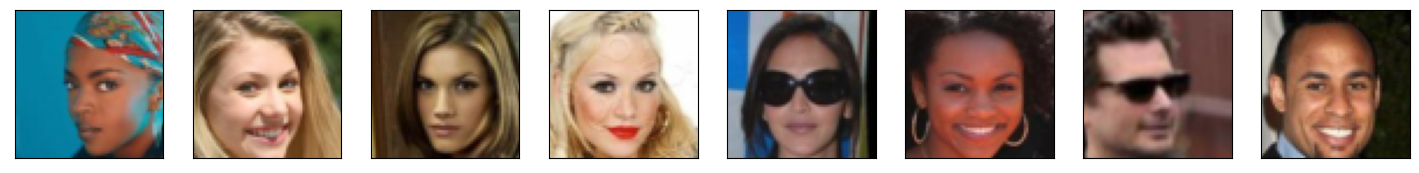

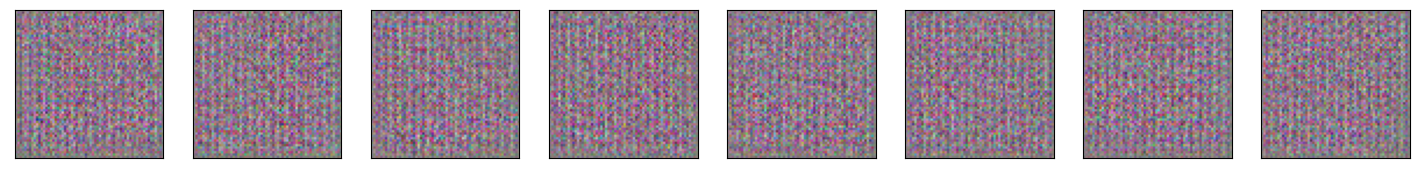

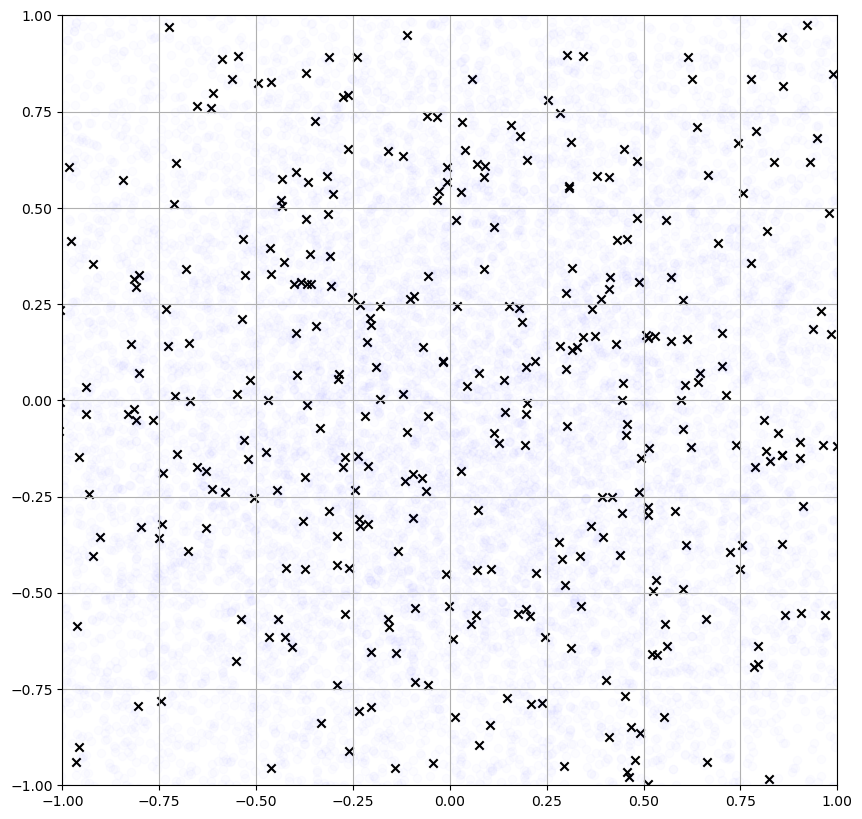

1
lse_loss 31.447662353515625
commit_loss 0.6280612945556641
recon_loss 0.11027991771697998
2
lse_loss 31.013078689575195
commit_loss 0.6204336881637573
recon_loss 0.09666977822780609
3
lse_loss 29.433231353759766
commit_loss 0.5960025787353516
recon_loss 0.09967748820781708
4
lse_loss 28.601648330688477
commit_loss 0.5868539810180664
recon_loss 0.09900655597448349
5
lse_loss 27.315048217773438
commit_loss 0.5687158107757568
recon_loss 0.09540432691574097
6
lse_loss 25.72540283203125
commit_loss 0.5501824617385864
recon_loss 0.09530489146709442
7
lse_loss 24.088424682617188
commit_loss 0.5318068265914917
recon_loss 0.09181626886129379
8
lse_loss 23.287147521972656
commit_loss 0.5272024869918823
recon_loss 0.08556312322616577
9
lse_loss 22.319210052490234
commit_loss 0.5218325257301331
recon_loss 0.09055715799331665
10
lse_loss 20.565303802490234
commit_loss 0.506142258644104
recon_loss 0.08656083792448044
11
lse_loss 19.17247772216797
commit_loss 0.49324724078178406
recon_loss 0.087037

lse_loss 6.573156356811523
commit_loss 0.17324642837047577
recon_loss 0.03210896998643875
91
lse_loss 6.4857025146484375
commit_loss 0.16251353919506073
recon_loss 0.03211870789527893
92
lse_loss 6.528142929077148
commit_loss 0.17261987924575806
recon_loss 0.029140515252947807
93
lse_loss 6.518360137939453
commit_loss 0.16558343172073364
recon_loss 0.029494117945432663
94
lse_loss 6.5568108558654785
commit_loss 0.17136269807815552
recon_loss 0.02877379022538662
95
lse_loss 6.413586616516113
commit_loss 0.1536913514137268
recon_loss 0.030764393508434296
96
lse_loss 6.493738174438477
commit_loss 0.16024640202522278
recon_loss 0.02820059470832348
97
lse_loss 6.451459884643555
commit_loss 0.15580947697162628
recon_loss 0.028942836448550224
98
lse_loss 6.499554634094238
commit_loss 0.15563705563545227
recon_loss 0.029895305633544922
99
lse_loss 6.456420421600342
commit_loss 0.15715861320495605
recon_loss 0.02932724729180336
100
lse_loss 6.509102821350098
commit_loss 0.1571120023727417
recon

179
lse_loss 6.945844650268555
commit_loss 0.12122863531112671
recon_loss 0.018600979819893837
180
lse_loss 6.931649684906006
commit_loss 0.12119247764348984
recon_loss 0.018086669966578484
181
lse_loss 6.925121307373047
commit_loss 0.1175641119480133
recon_loss 0.018199115991592407
182
lse_loss 6.9866228103637695
commit_loss 0.12482712417840958
recon_loss 0.017469314858317375
183
lse_loss 6.949513912200928
commit_loss 0.1159321665763855
recon_loss 0.01851387694478035
184
lse_loss 6.894159317016602
commit_loss 0.11242884397506714
recon_loss 0.015870464965701103
185
lse_loss 6.987975597381592
commit_loss 0.12502537667751312
recon_loss 0.019740276038646698
186
lse_loss 7.011617660522461
commit_loss 0.11903635412454605
recon_loss 0.01740396022796631
187
lse_loss 6.945006370544434
commit_loss 0.11051106452941895
recon_loss 0.017348885536193848
188
lse_loss 7.070267677307129
commit_loss 0.12281158566474915
recon_loss 0.018061332404613495
189
lse_loss 7.057733535766602
commit_loss 0.12390398

267
lse_loss 7.9136247634887695
commit_loss 0.09754657000303268
recon_loss 0.012628714554011822
268
lse_loss 7.876828670501709
commit_loss 0.09498012065887451
recon_loss 0.01337452232837677
269
lse_loss 7.903172492980957
commit_loss 0.09419748187065125
recon_loss 0.012998192571103573
270
lse_loss 7.922869682312012
commit_loss 0.0997384712100029
recon_loss 0.013131977990269661
271
lse_loss 7.884157657623291
commit_loss 0.09124109148979187
recon_loss 0.012868694961071014
272
lse_loss 7.923428535461426
commit_loss 0.08826469630002975
recon_loss 0.013588402420282364
273
lse_loss 7.954272270202637
commit_loss 0.09361117333173752
recon_loss 0.012749227695167065
274
lse_loss 7.957996368408203
commit_loss 0.09713475406169891
recon_loss 0.01277528889477253
275
lse_loss 7.920623779296875
commit_loss 0.08912691473960876
recon_loss 0.012742942199110985
276
lse_loss 8.047826766967773
commit_loss 0.09611821174621582
recon_loss 0.012603184208273888
277
lse_loss 7.994647026062012
commit_loss 0.0901910

354
lse_loss 9.067102432250977
commit_loss 0.08540378510951996
recon_loss 0.01086035743355751
355
lse_loss 9.034350395202637
commit_loss 0.07956188917160034
recon_loss 0.010782967321574688
356
lse_loss 9.042505264282227
commit_loss 0.08078286796808243
recon_loss 0.011013495735824108
357
lse_loss 9.030068397521973
commit_loss 0.07649427652359009
recon_loss 0.01082627009600401
358
lse_loss 9.042149543762207
commit_loss 0.08132068812847137
recon_loss 0.011917207390069962
359
lse_loss 9.113164901733398
commit_loss 0.08160027861595154
recon_loss 0.012533547356724739
360
lse_loss 9.10049819946289
commit_loss 0.08336635679006577
recon_loss 0.012113286182284355
361
lse_loss 9.08819580078125
commit_loss 0.08023513108491898
recon_loss 0.010934203863143921
362
lse_loss 9.113930702209473
commit_loss 0.08032045513391495
recon_loss 0.010533593595027924
363
lse_loss 9.14395523071289
commit_loss 0.0823366641998291
recon_loss 0.011721082031726837
364
lse_loss 9.11110782623291
commit_loss 0.078540965914

lse_loss 10.202760696411133
commit_loss 0.06832326948642731
recon_loss 0.010825201869010925
442
lse_loss 10.288822174072266
commit_loss 0.07373887300491333
recon_loss 0.009719102643430233
443
lse_loss 10.242511749267578
commit_loss 0.06880030035972595
recon_loss 0.009987035766243935
444
lse_loss 10.295588493347168
commit_loss 0.07164163887500763
recon_loss 0.009996705688536167
445
lse_loss 10.262638092041016
commit_loss 0.06509067863225937
recon_loss 0.009545831009745598
446
lse_loss 10.297164916992188
commit_loss 0.07057887315750122
recon_loss 0.009387066587805748
447
lse_loss 10.29751968383789
commit_loss 0.06763403117656708
recon_loss 0.009306097403168678
448
lse_loss 10.327322006225586
commit_loss 0.071846142411232
recon_loss 0.009771300479769707
449
lse_loss 10.34793472290039
commit_loss 0.06910566985607147
recon_loss 0.010229154489934444
450
lse_loss 10.344034194946289
commit_loss 0.06839734315872192
recon_loss 0.010153493843972683
451
lse_loss 10.36105728149414
commit_loss 0.068

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            distance_p = linear(1, 0.2, step, 0, 1000*1000)
            data = model(data, distance_p=distance_p)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')